In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.constants as const
import seaborn as sns

In [2]:
%matplotlib notebook

In [3]:
def Create_dataframes(filenames, directory, row_label):
    dataframes = {}
    for name in filenames:
        file_directory = f'{directory}/{name}.csv'
        data = pd.read_csv(file_directory, index_col=row_label)
        dataframes[name] = data
    return dataframes

def Ensure_all(All_variables):
    no_nan_tables = [table.dropna() for table in All_variables]
    
    num_variables = len(no_nan_tables)
    previous_merge = no_nan_tables[0]
    for index in range(1, num_variables):
        current_table = no_nan_tables[index]
        previous_merge = pd.merge(previous_merge, current_table, left_index=True, right_index=True, how='inner')
    return previous_merge

def Remove_rejects(All_variables, rejected_IDs):
    for variable_table in All_variables:
            variable_table.drop(rejected_IDs, inplace=True)
            
def Create_HR(dataframes, Teff_source, Rad_source):
    Teff_dataframe = dataframes[Teff_source]['Teff']
    Radius_dataframe = dataframes[Rad_source]['Radius']
    
    Total_data = [Teff_dataframe, Radius_dataframe]
    Filtered_data = Ensure_all(Total_data)
    Teff = Filtered_data['Teff']
    Radius = Filtered_data['Radius']
    
    Luminosity = Radius**2*(Teff/5772)**4
    return Teff, Luminosity

def Split_errors(database, variable_name, error_prefix=None, keep_columns=None):
    if error_prefix is None:
        error_prefix = variable_name
    try:
        if keep_columns is None:
            data = database[[f'{variable_name}', f'{error_prefix} pe', f'{error_prefix} me']]
        else:
            data = database[[f'{variable_name}', f'{error_prefix} pe', f'{error_prefix} me', *keep_columns]]
    except KeyError:
        half_pme = database[f'{error_prefix} pme']/2
        pe = half_pme.rename(f'{error_prefix} pe')
        me = half_pme.rename(f'{error_prefix} me')
        if keep_columns is None:
            data = database[f'{variable_name}']
        else:
            data = database[[f'{variable_name}', *keep_columns]]
            
        data = pd.merge(data, pe, left_index=True, right_index=True)
        data = pd.merge(data, me, left_index=True, right_index=True)
    return data

def Largest_error(errors, error_prefix):
    pe_column = f'{error_prefix} pe'
    me_column = f'{error_prefix} me'

    largest_errors = np.maximum(errors[pe_column], errors[me_column])

    return largest_errors

def Create_valley(starframes, planetframes, X_variable, X_error_prefix, X_source, PSR_source, Host_radii_source):
        
    #Checking for split errors
    PSR_data = Split_errors(planetframes[PSR_source], 'PSR', keep_columns=['Host Gaia DR3 ID'])
    
    #Checking for split errors
    Host_Radii_dataframe = Split_errors(starframes[Host_radii_source], 'Radius', 'Rad')
    
    if 'Planets' in X_source:
        X_data = Split_errors(planetframes[X_source], X_variable, X_error_prefix)
        Planet_data = [X_data, PSR_data]
        Planet_dataframe = Ensure_all(Planet_data).set_index('Host Gaia DR3 ID')
        Total_data = [Planet_dataframe, Host_Radii_dataframe]
    else:
        X_data = Split_errors(starframes[X_source], X_variable, X_error_prefix)
        Planet_dataframe = PSR_data.set_index('Host Gaia DR3 ID')
        Total_data = [Planet_dataframe, Host_Radii_dataframe, X_data]

    #Filtering out sources with no data and combining the dataframes
    Filtered_data = Ensure_all(Total_data)
    
    X = Filtered_data[X_variable]
    X_err = Filtered_data[[f'{X_error_prefix} pe', f'{X_error_prefix} me']]
    
    PSR = Filtered_data['PSR']
    PSR_err = Largest_error(Filtered_data, 'PSR')
    
    Host_Radii = Filtered_data['Radius']
    Host_Radii_err = Largest_error(Filtered_data, 'Rad')
    
    Sun_Earth = const.R_sun/const.R_earth
    Planet_Radii = PSR*Host_Radii*Sun_Earth
    Planet_Radii_err = Sun_Earth*np.sqrt(Host_Radii**2*PSR_err**2 + PSR**2*Host_Radii_err**2)
        
    return X, X_err, Planet_Radii, Planet_Radii_err

In [4]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
#Main_directory = 'C:/Users/georg/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
All_stars_directory = f'{Main_directory}/Sorted Data/Stars'
All_planets_directory = f'{Main_directory}/Sorted Data/Planets'

star_filenames = ['Gaia All Stars', 'Exo All Stars', 'Fulton All Stars', 'VanEylen All Stars', 'BASTA All Stars', 'Grid test']
planet_filenames = ['HoVan All Planets', 'Fulton All Planets', 'VanEylen All Planets', 'Exo All Planets']

starframes = Create_dataframes(star_filenames, All_stars_directory, 'Gaia DR3 ID')
planetframes = Create_dataframes(planet_filenames, All_planets_directory, 'KOI')

<IPython.core.display.Javascript object>


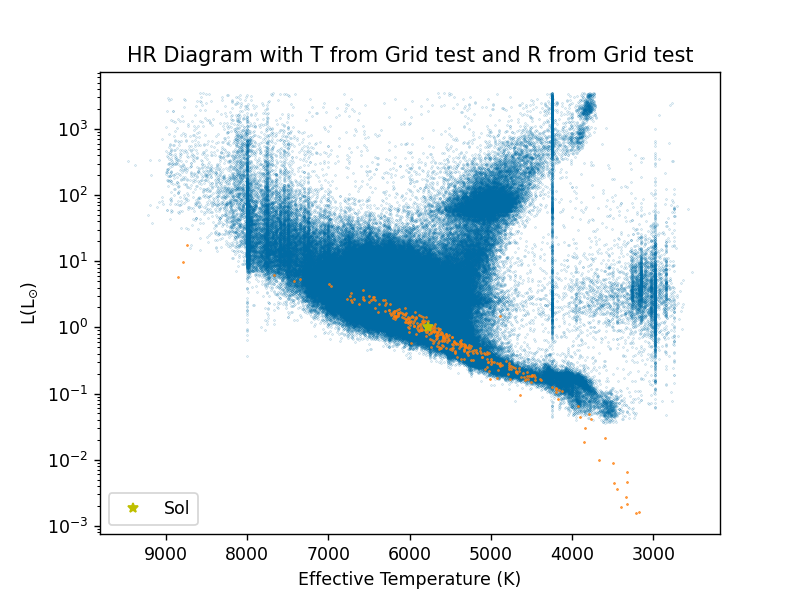

In [15]:
Dataset1 = 'Grid test'
Dataset2 = 'Grid test'

Teff, Luminosity = Create_HR(starframes, Dataset1, Dataset2)

HR_data = pd.read_csv(f'{Main_directory}/Raw Data/HR Data (Flags).csv')
def Gaia_flag(flag, wanted_flag):
    if flag != wanted_flag:
        flag = None
    return flag

HR_data['flags_flame'] = HR_data['flags_flame'].apply(Gaia_flag, args=[0])
HR_data.dropna(inplace=True)

Title = f'HR Diagram with T from {Dataset1} and R from {Dataset2}'
Colour = plt.style.use('tableau-colorblind10')

plt.figure()
plt.plot(HR_data['teff_gspspec'], HR_data['lum_flame'], '.', color=Colour, markersize=0.5, alpha=0.4)
plt.plot(Teff, Luminosity, '.', color=Colour, markersize=1)
plt.plot(5772, 1, 'y*', label='Sol')
plt.ylabel('L(L$_{\odot}$)')
plt.xlabel('Effective Temperature (K)')
plt.title(Title)
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


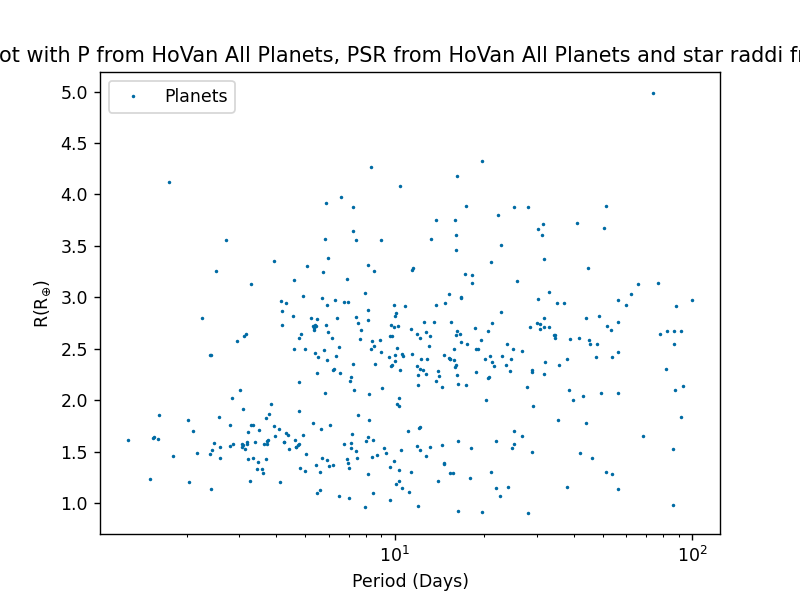

In [21]:
P_dataset = 'HoVan All Planets'
PSR_dataset = 'HoVan All Planets'
Radius_dataset = 'Gaia All Stars'

P, P_err, Planet_Radii, Planet_Radii_err = Create_valley(starframes, planetframes, 'P', 'P', P_dataset, PSR_dataset, Radius_dataset)

Title = f'Radius valley plot with P from {P_dataset}, PSR from {PSR_dataset} and star raddi from {Radius_dataset}'

plt.figure()
plt.plot(P, Planet_Radii, '.', color=Colour, markersize=2, label='Planets')
#plt.plot(365, 1, 'b.', label='Earth')
plt.xscale('log')
plt.xlabel('Period (Days)')
plt.ylabel('R(R$_{\oplus})$')
plt.title(Title)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


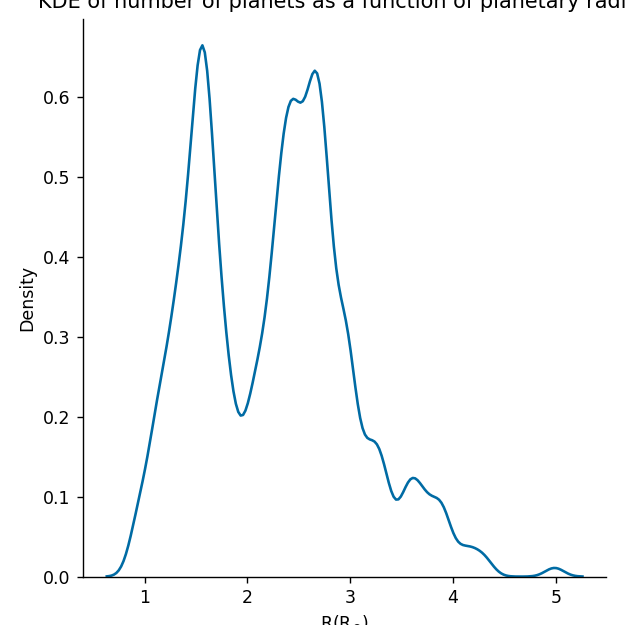

C:\Users\Iwan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [37]:
sns.displot(Planet_Radii, kind="kde", bw_adjust=.4).set(title='KDE of number of planets as a function of planetary radius',
                                                       xlabel='R(R$_{\oplus})$')